In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/tom/coding/ExTRApack/')
import ExTRA as ex

ExTRA correctly imported


# HIP Mockdata

In [2]:
#The hip standard model solution can be read of online.
#For the purpose of showing, here is just a simple example:
asc=20
dec=-10
parallax=200
mu_a_star=-100
mu_d=+300

hip_stand=asc,dec,parallax,mu_a_star,mu_d


In [3]:
HIP=ex.hip_read("mock_HIP.txt")
hip_ad=HIP[0] #A3,A4,A5,A6,A7,A8,A9=HIP[0] this is needed for fitting !!!


A3,A4,A5,A6,A7,A8,A9=HIP[0] 
t_hip=HIP[1] #time of measurements in JD, for plots

# RV Mockdata

In [4]:
RV_data=ex.RV_read("mock_RV.txt")
t_RV,RV,RV_err=RV_data #timestamps,RVs,error

## Working with the data

### 1) Plotting HIP data

In [5]:
x,x_err,y,y_err=ex.hip_2d(A3,A4,A8,A9) #Rotates the HIP measurements into the RA,Dec frame.

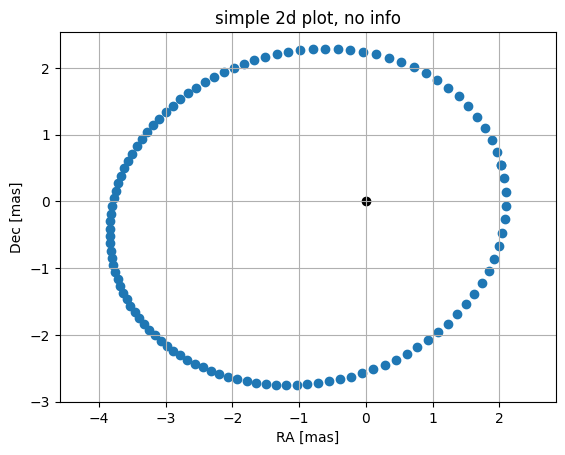

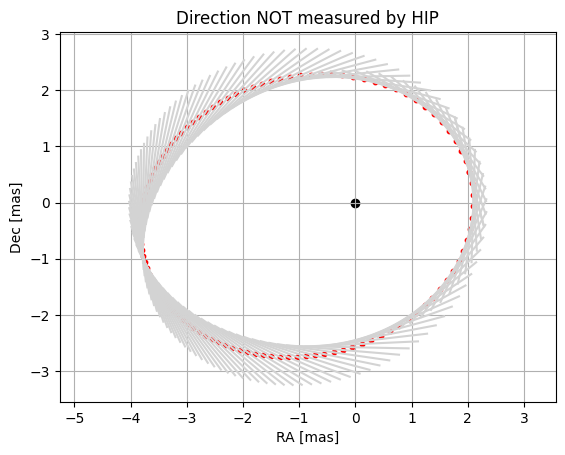

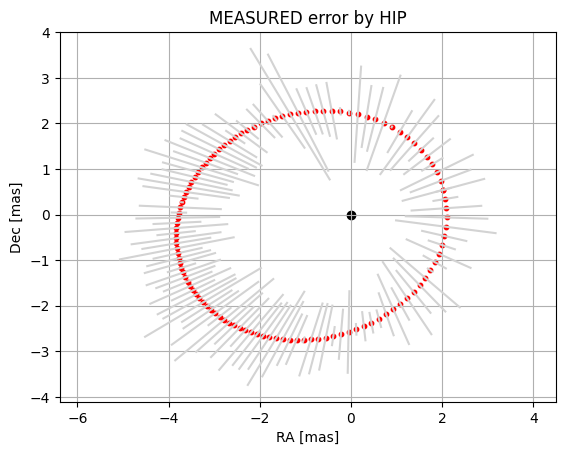

In [6]:
plt.title("simple 2d plot, no info")
plt.scatter(x,y)
plt.scatter(0,0,color="k")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.axis("equal")
plt.grid()
plt.show()



ex.plot_hip(x,x_err,y,y_err)

plt.title("Direction NOT measured by HIP")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.scatter(0,0,color="k")
plt.axis("equal")
plt.grid()
plt.show()




ex.plot_hip_err(x,x_err,y,y_err,s=10)

plt.title("MEASURED error by HIP")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.scatter(0,0,color="k")
plt.axis("equal")
plt.grid()
plt.show()


### 2) Fitting 

#### 2.1) just HIP (important for Trifon)

In [7]:
#For simplicity i assume gaia and HIP to have the same exact solution, but usually the gaia solution is different from the HIP
#solution and way more accurate
gaia=hip_stand
#standard epochs
J1991=2448349.0 #1991.25
J2000=2451545.0
J2016=2457389.0


In [14]:
#Parameters #taken from the datawrite file
correction=np.array([0,0,0,0,0])

P=550
e=0.3
om=np.radians(0)
i=np.radians(30)
Om=np.radians(75)
T0=J1991+900 #900 days after standard 1991
a=3

In [15]:
ex.L_hip(hip_ad,hip_stand,gaia, #Data
         correction,P,e,om,i,Om,T0,a, #parameters
         s_hip=0)#jitter

1308.1357546850363

### 2.2) RV+ HIP

In [10]:
v_array=np.array([0])

In [11]:
ex.L_combined(RV,RV_err,t_RV,
              hip_ad,hip_stand,
              gaia,
              #Parameters:
              v_array,
              correction,P,e,om,i,Om,T0,a,
              s_RVs=0,s_hip=0) #jitters

1717.503353566895